In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=4)


In [14]:
# Inputs (4 samples, 2 features)
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]], dtype=float)

# Labels (4 samples, 1 output)
y = np.array([[0],
              [0],
              [0],
              [1]], dtype=float)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nX:\n", X)
print("\ny:\n", y)


X shape: (4, 2)
y shape: (4, 1)

X:
 [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

y:
 [[0.]
 [0.]
 [0.]
 [1.]]


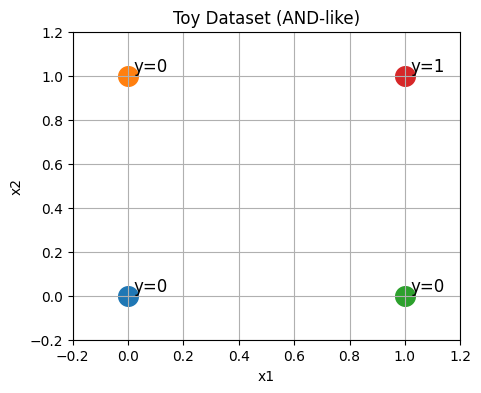

In [15]:
plt.figure(figsize=(5,4))
for i in range(len(X)):
    plt.scatter(X[i,0], X[i,1], s=200)
    plt.text(X[i,0]+0.02, X[i,1]+0.02, f"y={int(y[i,0])}", fontsize=12)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Toy Dataset (AND-like)")
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()


In [16]:
np.random.seed(42)

# Layer 1: 2 -> 4
W1 = np.random.randn(2, 4) * 0.5
b1 = np.zeros((1, 4))

# Layer 2: 4 -> 1
W2 = np.random.randn(4, 1) * 0.5
b2 = np.zeros((1, 1))

print("W1:", W1.shape, "b1:", b1.shape)
print("W2:", W2.shape, "b2:", b2.shape)


W1: (2, 4) b1: (1, 4)
W2: (4, 1) b2: (1, 1)


In [17]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [18]:
def binary_cross_entropy(y_true, y_pred, eps=1e-8):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))



## 6. Backpropagation (Gradients)

We compute gradients for:
- \(W_2, b_2\) using output error
- then propagate error to hidden layer to compute \(W_1, b_1\)

For sigmoid + BCE, a helpful simplification is:
\[
\frac{\partial L}{\partial z_2} = \hat{y} - y
\]

Then:
- \(dW_2 = a_1^T dz_2\)
- \(db_2 = \sum dz_2\)
- propagate: \(da_1 = dz_2 W_2^T\)
- apply ReLU derivative: \(dz_1 = da_1 \odot ReLU'(z_1)\)
- \(dW_1 = X^T dz_1\)
- \(db_1 = \sum dz_1\)


In [19]:
def backward_pass(X, y, cache, W2):
    z1, a1, y_hat = cache["z1"], cache["a1"], cache["y_hat"]

    # Output layer gradient
    dz2 = y_hat - y                        # (N,1)
    dW2 = a1.T @ dz2                       # (4,1)
    db2 = np.sum(dz2, axis=0, keepdims=True)  # (1,1)

    # Hidden layer gradient
    da1 = dz2 @ W2.T                       # (N,4)
    dz1 = da1 * relu_derivative(z1)        # (N,4)
    dW1 = X.T @ dz1                        # (2,4)
    db1 = np.sum(dz1, axis=0, keepdims=True)  # (1,4)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

grads = backward_pass(X, y, cache, W2)
for k,v in grads.items():
    print(k, v.shape)


dW1 (2, 4)
db1 (1, 4)
dW2 (4, 1)
db2 (1, 1)


In [20]:
def train_mlp(X, y, hidden_size=4, lr=0.1, epochs=5000, seed=42, print_every=500):
    np.random.seed(seed)

    # Initialize
    W1 = np.random.randn(X.shape[1], hidden_size) * 0.5
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, 1) * 0.5
    b2 = np.zeros((1, 1))

    losses = []

    for epoch in range(1, epochs+1):
        # Forward
        y_hat, cache = forward_pass(X, W1, b1, W2, b2)
        loss = binary_cross_entropy(y, y_hat)
        losses.append(loss)

        # Backward
        grads = backward_pass(X, y, cache, W2)

        # Update
        W1 -= lr * grads["dW1"]
        b1 -= lr * grads["db1"]
        W2 -= lr * grads["dW2"]
        b2 -= lr * grads["db2"]

        if epoch % print_every == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Loss: {loss:.4f}")

    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return params, losses

params, losses = train_mlp(X, y, hidden_size=4, lr=0.1, epochs=5000, print_every=500)


Epoch    1 | Loss: 0.7045
Epoch  500 | Loss: 0.0068
Epoch 1000 | Loss: 0.0033
Epoch 1500 | Loss: 0.0021
Epoch 2000 | Loss: 0.0016
Epoch 2500 | Loss: 0.0013
Epoch 3000 | Loss: 0.0011
Epoch 3500 | Loss: 0.0009
Epoch 4000 | Loss: 0.0008
Epoch 4500 | Loss: 0.0007
Epoch 5000 | Loss: 0.0006


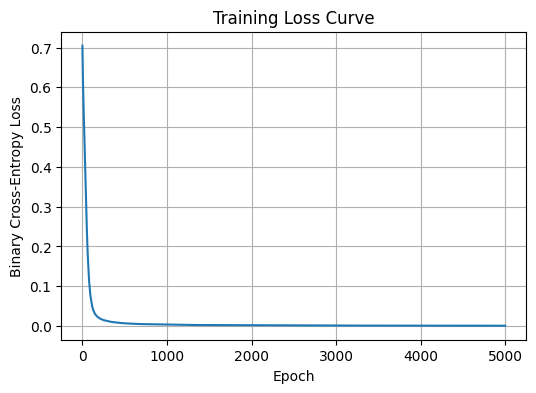

In [21]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [22]:
W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]

y_hat, _ = forward_pass(X, W1, b1, W2, b2)
pred = (y_hat >= 0.5).astype(int)

print("Final y_hat probabilities:\n", y_hat)
print("\nPredicted labels:\n", pred)
print("\nTrue labels:\n", y.astype(int))


Final y_hat probabilities:
 [[0.    ]
 [0.0021]
 [0.0001]
 [0.9998]]

Predicted labels:
 [[0]
 [0]
 [0]
 [1]]

True labels:
 [[0]
 [0]
 [0]
 [1]]


Epoch    1 | Loss: 0.7114
Epoch  800 | Loss: 0.4780
Epoch 1600 | Loss: 0.4776
Epoch 2400 | Loss: 0.4775
Epoch 3200 | Loss: 0.4775
Epoch 4000 | Loss: 0.4775
Epoch 4800 | Loss: 0.4775
Epoch 5600 | Loss: 0.4774
Epoch 6400 | Loss: 0.4774
Epoch 7200 | Loss: 0.4774
Epoch 8000 | Loss: 0.4774
XOR probabilities:
 [[0.6666]
 [0.6666]
 [0.6666]
 [0.0002]]
XOR predicted labels:
 [[1]
 [1]
 [1]
 [0]]
XOR true labels:
 [[0]
 [1]
 [1]
 [0]]


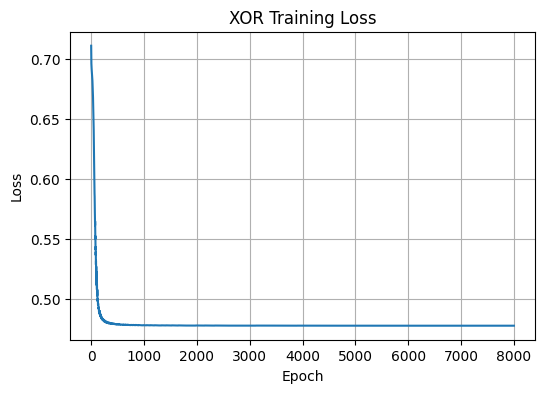

In [24]:
# XOR dataset (uncomment to try)
X_xor = np.array([[0,0],
                  [0,1],
                  [1,0],
                  [1,1]], dtype=float)
y_xor = np.array([[0],
                  [1],
                  [1],
                  [0]], dtype=float)

params_xor, losses_xor = train_mlp(X_xor, y_xor, hidden_size=4, lr=0.1, epochs=8000, print_every=800)
W1, b1, W2, b2 = params_xor["W1"], params_xor["b1"], params_xor["W2"], params_xor["b2"]
y_hat_xor, _ = forward_pass(X_xor, W1, b1, W2, b2)
pred_xor = (y_hat_xor >= 0.5).astype(int)
print("XOR probabilities:\n", y_hat_xor)
print("XOR predicted labels:\n", pred_xor)
print("XOR true labels:\n", y_xor.astype(int))

plt.figure(figsize=(6,4))
plt.plot(losses_xor)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("XOR Training Loss")
plt.grid(True)
plt.show()
